In [2]:
import numpy as np
from PIL import Image, ImageDraw
from tqdm import tqdm
import matplotlib.pyplot as plt
from copy import deepcopy
from IPython.display import clear_output


In [55]:
class Polygon:
   def __init__(self, vertices=3, high=[256, 256]):
      self.cords = np.random.randint(low=[0, 0], high=high, size=(vertices, 2))
      self.rgba = np.random.normal(128, 50, size = 4).astype(int)

class ImageGAScaling:
   def __init__(self, images, tresholds, gif_name="default", iterations=100000, children_size=150, tick=100, increment=100):
      self.images = images
      self.tresholds = tresholds
      self.current_treshold = 0
      self.og_image = images[0]
      self.og_image_data = np.asarray(self.og_image, dtype=np.int32)
      self.img_w, self.img_h = self.og_image.size
      self.img_obj = Image.new("RGB",(self.img_w, self.img_h))
      self.iterations = iterations
      self.population_size = 1
      self.children_size = children_size
      self.individual_size = 3
      self.gif_name = gif_name
      self.population = []
      self.fitness_history = []
      self.gif_frames = []
      self.polygon_vertices = 3
      self.tick = tick
      self.global_best = 100000000000
      self.to_mutate = 3
      self.increment = increment

   def get_individual(self):
      return np.array([Polygon(self.polygon_vertices, [self.img_w, self.img_h]) for _ in range(self.individual_size)])

   def get_random_population(self):
      return np.array([self.get_individual() for _ in range(self.population_size)])

   def mutate(self, individual_og):
      individual = deepcopy(individual_og)
      id = np.random.randint(low=individual.size -
                             self.to_mutate, high=individual.size)
      pol = individual[id]
      for i in range(4):
         pol.rgba[i] = min(max(0, np.random.normal(pol.rgba[i], 15)), 255)
      id = np.random.randint(
          low=0, high=self.polygon_vertices, size=1)

      new_cords = np.random.normal(
          pol.cords[id], [self.img_w / 8, self.img_h / 8])
      new_cords[new_cords < 0] = 0
      if new_cords[0][0] > self.img_w:
         new_cords[0][0] = self.img_w
      if new_cords[0][1] > self.img_h:
         new_cords[0][1] = self.img_h
      pol.cords[id] = new_cords
      return individual

   def get_image(self, individual):
      image = deepcopy(self.img_obj)
      draw = ImageDraw.Draw(image, "RGBA")
      for i in range(individual.size - self.to_mutate, individual.size):
         pol = individual[i]
         draw.polygon(tuple(map(tuple, pol.cords)), tuple(pol.rgba))
      return image

   def objective_function(self, individual):
      image_data = np.asarray(self.get_image(individual), dtype=np.int32)
      return np.sum((image_data - self.og_image_data)**2 / (self.img_w * self.img_h))

   def best_idx(self, p_v, k):
       return np.argpartition(p_v, k)[:k]

   def update_img_data(self):
       self.current_treshold += 1
       self.og_image = self.images[self.current_treshold]
       self.og_image_data = np.asarray(self.og_image, dtype=np.int32)
       self.img_obj = Image.new("RGB", self.og_image.size)
       draw = ImageDraw.Draw(self.img_obj, "RGBA")
       for pop in self.population:
           counter=0
           for pol in pop:
               for i in range(self.polygon_vertices):
                    cords = pol.cords[i]
                    percentages = cords / [self.img_w, self.img_h]
                    pol.cords[i] = percentages * self.og_image.size
               if counter < self.individual_size-self.to_mutate-1:
                  draw.polygon(tuple(map(tuple, pol.cords)),tuple(pol.rgba))
               counter += 1

       self.img_w, self.img_h = self.og_image.size

   def update_gif(self):
       self.gif_frames[0].save(self.gif_name+f'-part{self.current_treshold-1}.gif', format='GIF',
                              append_images=self.gif_frames[1:], save_all=True, duration=4, loop=0)
       self.gif_frames = []

   def run(self):
      self.population = self.get_random_population()
      for t in tqdm(range(self.iterations), desc=f'Evolving'):
         if (t + 1) % self.increment == 0:
            self.individual_size += 1
            if self.tresholds[self.current_treshold] == self.individual_size:
                self.update_img_data()
                self.update_gif()
                self.increment += 25

            draw = ImageDraw.Draw(self.img_obj, "RGBA")
            draw.polygon(
                tuple(map(tuple, self.population[0][self.individual_size-self.to_mutate-1].cords)),
                tuple(self.population[0][self.individual_size-self.to_mutate-1].rgba))

            arr = np.array([Polygon(self.polygon_vertices, [self.img_w, self.img_h]) for _ in range(self.population_size)])
            self.population = np.concatenate(
                (self.population, arr[:, None]), axis=1)

         population_values = np.array(
             [self.objective_function(x) for x in self.population])
         self.population = np.array([self.population[i] for i, _ in sorted(
             enumerate(population_values), key=lambda x: x[1])])
         population_values.sort()

         self.fitness_history.append(population_values[0])

         new_population = []

         for i in range(self.population_size):
            for j in range(self.children_size):
               new_population.append(self.mutate(self.population[i]))

         new_population = np.array(new_population)
         new_population_values = np.array(
             [self.objective_function(x) for x in new_population])
         new_population = np.array([new_population[i] for i, _ in sorted(
             enumerate(new_population_values), key=lambda x: x[1])])
         new_population_values.sort()

         self.population = np.concatenate((self.population, new_population))
         population_values = np.concatenate(
             (population_values, new_population_values))

         self.population = np.array([self.population[i] for i, _ in sorted(
             enumerate(population_values), key=lambda x: x[1])][:self.population_size])

         best_guy = self.population[0]
         self.global_best = min(self.global_best, population_values[0])

         gif_frame = self.get_image(best_guy)
         if t % self.tick == 0:
            gif_frame.save(self.gif_name + '.png', quality='keep')
            self.gif_frames.append(gif_frame)

      gif_frame.save(self.gif_name + '.png', quality='keep')
      self.gif_frames.append(gif_frame)
      self.gif_frames[0].save(self.gif_name+f'-part{self.current_treshold}.gif', format='GIF',
                              append_images=self.gif_frames[1:], save_all=True, duration=4, loop=0)

   def plot_cost(self):
       plt.figure(figsize=(20, 10))
       plt.plot(self.fitness_history)
       plt.title(f'BEST: {self.global_best :.3f}')
       plt.legend(['Min'], loc='upper right')


Evolving: 100%|██████████| 25099/25099 [16:42:19<00:00,  2.40s/it]  


number of triangles used:  272


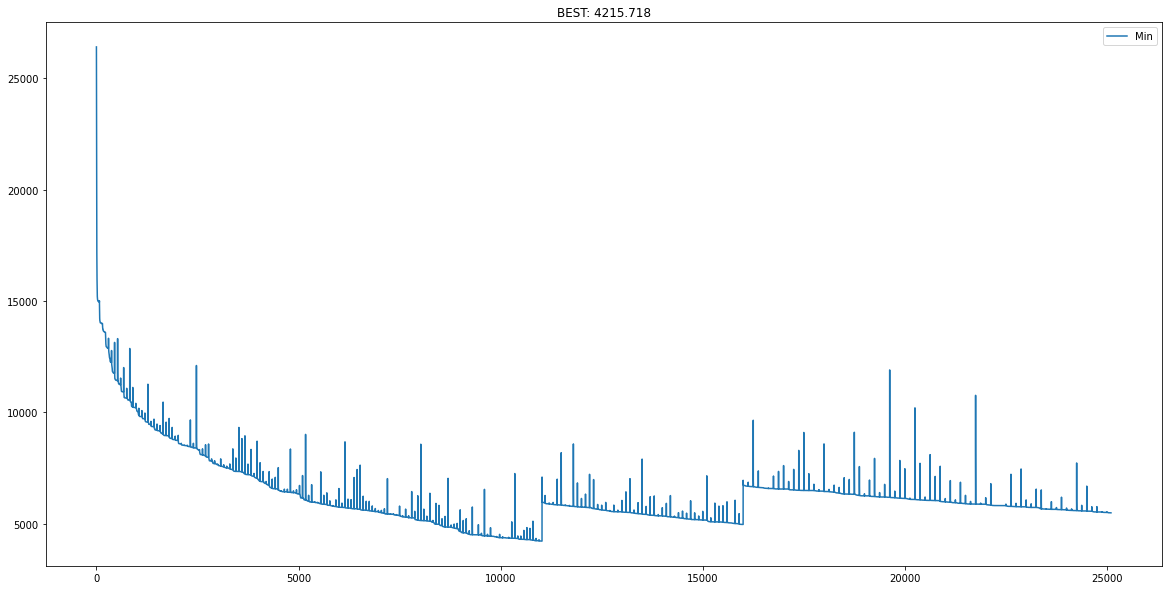

In [54]:
img1 = Image.open("../images/faces150x150.jpg").convert("RGB")
img2 = Image.open("../images/faces300x300.jpg").convert("RGB")
img3 = Image.open("../images/faces900x900.jpg").convert("RGB")


test = ImageGAScaling([img1, img2, img3],[150, 200, 100000], children_size=500,
                       tick=50, gif_name="faces-scaling-25k", iterations=25099, increment=75)
test.run()
test.plot_cost()
print("number of triangles used: ", test.individual_size)

Evolving: 100%|██████████| 45099/45099 [35:16:45<00:00,  2.82s/it]   


number of triangles used:  265


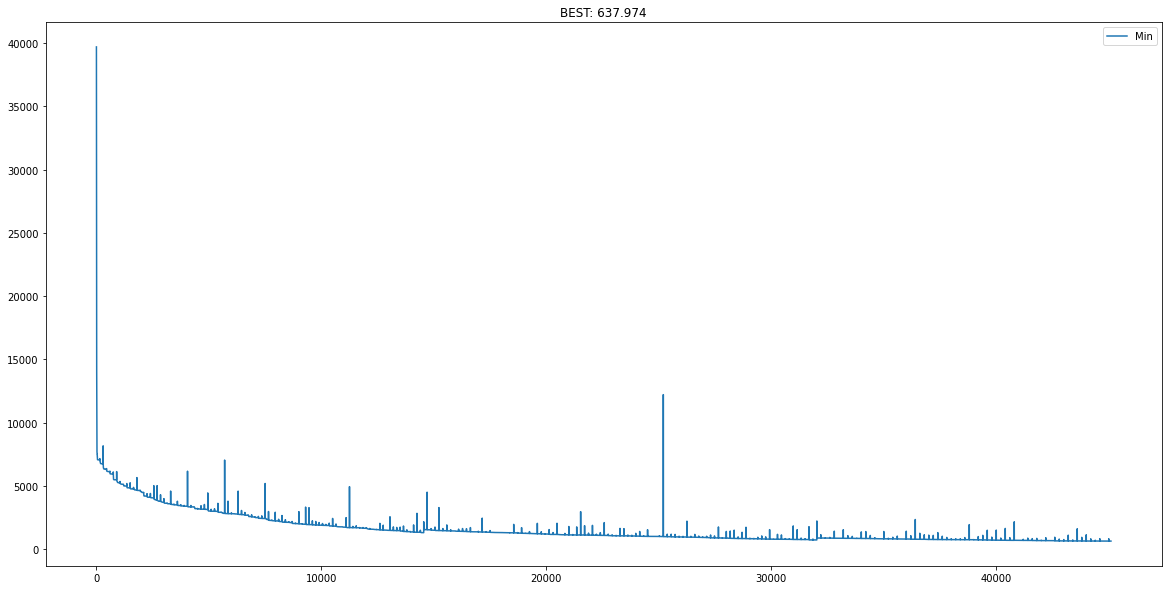

In [57]:
img1 = Image.open("../images/geometric-small.jpg").convert("RGB")
img2 = Image.open("../images/geometric-medium.jpg").convert("RGB")
img3 = Image.open("../images/geometric-big.jpg").convert("RGB")


geometric = ImageGAScaling([img1, img2, img3],[100, 200, 100000], children_size=500,
                       tick=50, gif_name="geometric-45k", iterations=45099, increment=150)
geometric.run()
geometric.plot_cost()
print("number of triangles used: ", geometric.individual_size)

Evolving: 100%|██████████| 45099/45099 [34:10:24<00:00,  2.73s/it]   


number of triangles used:  285


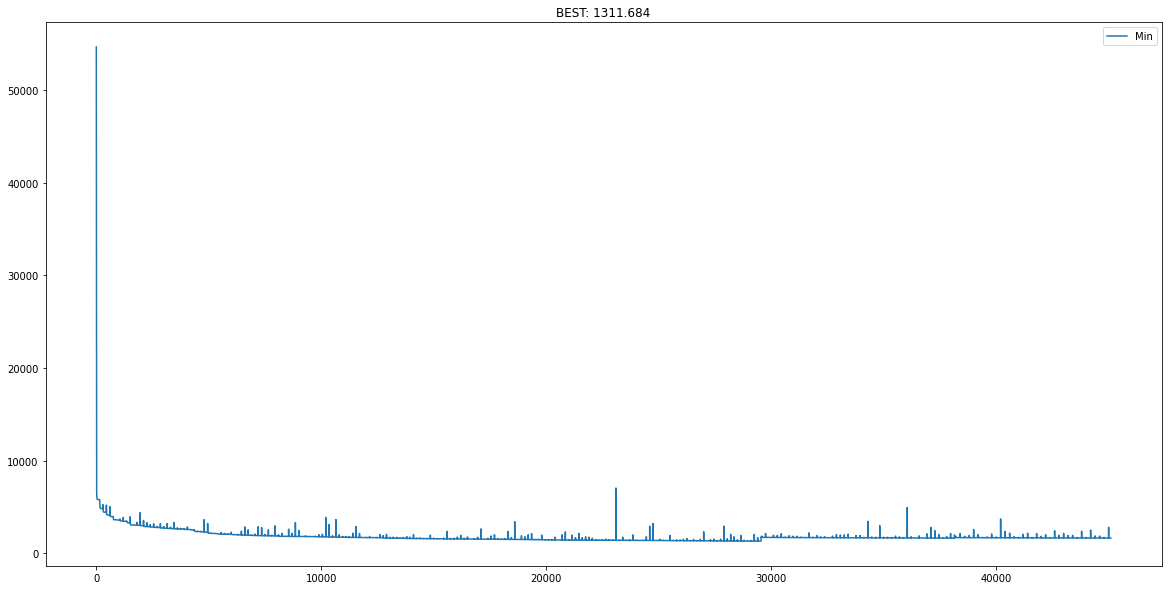

In [59]:
img1 = Image.open("../images/van-gogh240x240.jpg").convert("RGB")
img2 = Image.open("../images/van-gogh480x480.jpg").convert("RGB")
img3 = Image.open("../images/van-gogh1200x1200.jpg").convert("RGB")


gogh = ImageGAScaling([img1, img2, img3],[200, 250, 100000], children_size=500,
                       tick=50, gif_name="van-gogh-45k", iterations=45099, increment=150)
gogh.run()
gogh.plot_cost()
print("number of triangles used: ", gogh.individual_size)